In [9]:
import pandas as pd
pd.options.display.max_columns = 100

In [10]:
all_muts_df = pd.read_pickle("./data/2_2_1_df.pkl")
display(all_muts_df.shape)

(2641, 27)

In [11]:
MUT_DESCRIPTORS = ["Position", "Mutation Type", "Details", "Sequence Change", "mutation target annotation"]


exp_mut_cnt_df = pd.DataFrame()
for exp, exp_mut_df in all_muts_df.groupby("exp"):
    
    exp_mut_cnt_df = exp_mut_cnt_df.append({
        "type": "mutations",
        "per experiment": "all",
        "experiment name": exp,
        "mutation count": len(exp_mut_df),
    }, ignore_index=True)
    
    df = exp_mut_df[MUT_DESCRIPTORS].copy()
    df = df.drop_duplicates()
    exp_mut_cnt_df = exp_mut_cnt_df.append({
        "type": "mutations",
        "per experiment": "unique",
        "experiment name": exp,
        "mutation count": len(df),
    }, ignore_index=True)

In [12]:
for exp, exp_mut_df in all_muts_df.groupby("exp"):
    feat_cnt_d = dict()
    for _, r in exp_mut_df.iterrows():
        for feat_d in r["genomic features"]:
            feat = feat_d["RegulonDB ID"]
            if feat not in feat_cnt_d.keys():
                feat_cnt_d[feat] = 0
            feat_cnt_d[feat] += 1
    
    mut_feat_cnt = sum(v for v in feat_cnt_d.values())
    exp_mut_cnt_df = exp_mut_cnt_df.append({
        "type": "mutated genomic features",
        "per experiment": "all",
        "experiment name": exp,
        "mutation count": mut_feat_cnt,
    }, ignore_index=True)
    
    uniq_mut_feat_cnt = len(feat_cnt_d.keys())
    exp_mut_cnt_df = exp_mut_cnt_df.append({
        "type": "mutated genomic features",
        "per experiment": "unique",
        "experiment name": exp,
        "mutation count": uniq_mut_feat_cnt,
    }, ignore_index=True)

In [13]:
# currently returns the RegulonDB IDs, but that's fine since just currently getting counts.
def _get_feat_cnt_d(mut_df, feat_link_d_col):
    feat_cnt_d = dict()
    for _, r in mut_df.iterrows():
        for feat, links in r[feat_link_d_col].items():
            if feat not in feat_cnt_d.keys():
                feat_cnt_d[feat] = 0
            feat_cnt_d[feat] += len(links)
    return feat_cnt_d

for exp, exp_mut_df in all_muts_df.groupby("exp"):
    feat_cnt_d = _get_feat_cnt_d(exp_mut_df, "genetic feature links")
    
    mut_feat_cnt = sum(v for v in feat_cnt_d.values())
    exp_mut_cnt_df = exp_mut_cnt_df.append({
        "type": "mutated genetic features",
        "per experiment": "all",
        "experiment name": exp,
        "mutation count": mut_feat_cnt,
    }, ignore_index=True)
    
    uniq_mut_feat_cnt = len(feat_cnt_d.keys())
    exp_mut_cnt_df = exp_mut_cnt_df.append({
        "type": "mutated genetic features",
        "per experiment": "unique",
        "experiment name": exp,
        "mutation count": uniq_mut_feat_cnt,
    }, ignore_index=True)

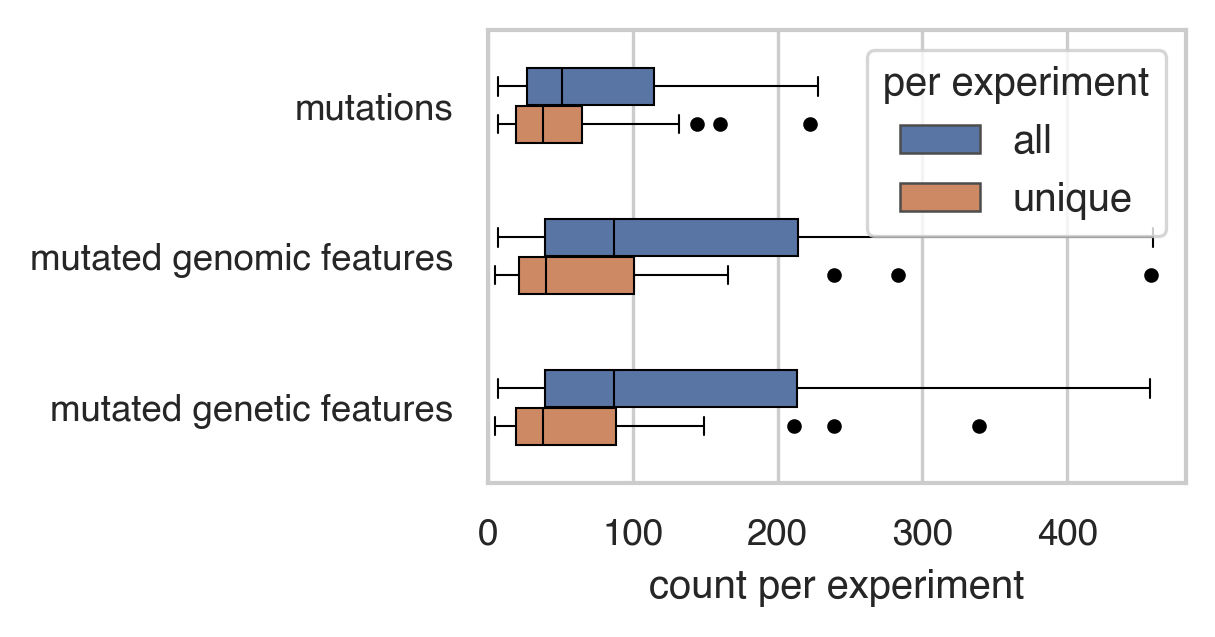

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["Helvetica"]
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("deep")


boxplot_kwargs = {
    'boxprops': {'edgecolor': 'k', 'linewidth': 0.5},
    'whiskerprops': {'color': 'k', 'linewidth': 0.5},
#     'medianprops': {'color': 'orange', 'linewidth': 1},
    'medianprops': {'color': 'k', 'linewidth': 0.5},
    'capprops': {'color': 'k', 'linewidth': 0.5},
    'flierprops': {'marker': '.', 'markerfacecolor': 'black', 'markeredgecolor': None}
}


plt.figure(figsize=(3, 2))
ax = sns.boxplot(data=exp_mut_cnt_df,
                 x="mutation count",
                 y="type",
                 hue="per experiment",
                 width=0.5,
#                  color="white",
#                  order=FEAT_ORDER_L,
                 **boxplot_kwargs)
# plt.xscale('log')
plt.xlim(0, None)
# plt.xlim(0, 1000)

for tick in ax.get_xticklabels(): tick.set_fontname("Helvetica")
for tick in ax.get_yticklabels(): tick.set_fontname("Helvetica")
ax.set_xlabel("count per experiment", fontname="Helvetica")
ax.set_ylabel("", fontname="Helvetica")

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Helvetica', style='normal',)
ax.legend(prop=font).set_title('per experiment', prop=font)
plt.savefig("fig.svg", format="svg")

In [15]:
# check for ASW-1628
# Genetic feature mutation counts being higher than genomic feature mutation counts has proven in the past to be problemmatic.
# The below code checks for these types of problems.
tdf = exp_mut_cnt_df[(exp_mut_cnt_df["per experiment"]=="all")&(exp_mut_cnt_df["type"].isin(["mutated genomic features", "mutated genetic features"]))]
for e, df in tdf.groupby(["experiment name"]):
    for _, r in df.iterrows():
        print(r["experiment name"] + " " + r["type"] + " " + str(r["mutation count"]))

42C mutated genomic features 234.0
42C mutated genetic features 234.0
C13 mutated genomic features 39.0
C13 mutated genetic features 39.0
Central_carbon_knockout_PTS mutated genomic features 40.0
Central_carbon_knockout_PTS mutated genetic features 40.0
Central_carbon_knockout_glucose_evolution mutated genomic features 15.0
Central_carbon_knockout_glucose_evolution mutated genetic features 15.0
Central_carbon_knockout_gnd mutated genomic features 28.0
Central_carbon_knockout_gnd mutated genetic features 28.0
Central_carbon_knockout_pgi mutated genomic features 195.0
Central_carbon_knockout_pgi mutated genetic features 193.0
Central_carbon_knockout_sdh mutated genomic features 23.0
Central_carbon_knockout_sdh mutated genetic features 23.0
Central_carbon_knockout_tpiA mutated genomic features 65.0
Central_carbon_knockout_tpiA mutated genetic features 65.0
GLU mutated genomic features 163.0
GLU mutated genetic features 163.0
GYD mutated genomic features 168.0
GYD mutated genetic features 

In [16]:
muts_df = all_muts_df[all_muts_df.exp=="TOL_propanediol"]
for _, r in muts_df.iterrows():
    display(r["Sequence Change"], r["genetic feature links"])

'Δ776 bp'

{'ECK120001080': ['ECK120001080'],
 'ECK125229290': ['ECK125229290'],
 'ECK125229291': ['ECK125229291']}

'Δ1,199 bp'

{'ECK125229292': ['ECK125229292'],
 'ECK125121991': ['ECK125121991'],
 'ECK125135293': ['ECK125135293'],
 'ECK125229292/ECK120000667': []}

'Δ776 bp'

{'ECK120003617': ['ECK120003617'],
 'ECK120023915': ['ECK125095446', 'ECK120013472', 'ECK120023915'],
 'ECK120003616': ['ECK120003616'],
 'ECK120000314/ECK120023915': ['ECK120017150'],
 'ECK120003617/ECK120003618': ['ECK120034252']}

'Δ2 bp'

{'ECK120002276': ['ECK120002276']}

'IS2 (–) +5 bp'

{'ECK120002026/ECK120003759': ['ECK125144315']}

'IS2 (+) +5 bp'

{'ECK120003886': ['ECK120003886']}

'A→C'

{'ECK120003950': ['ECK120003950']}

'C→A'

{'ECK120000884': ['ECK120000884']}

'+G'

{'ECK120000393': ['ECK120000393']}

'C→A'

{'ECK120001361': ['ECK120001361']}

'A→C'

{'ECK120001859/ECK120001860': ['ECK125138003']}

'+GC'

{'ECK120000398/ECK120001878': ['ECK120000398/ECK120001878']}